## Movie recommendations using item based collaborative filtering technique

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(font_scale=1.35)
%matplotlib inline

In [2]:
print(sys.version)
print('pandas:',pd.__version__)
print('numpy:',np.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
pandas: 1.2.3
numpy: 1.19.2


### Read users rating and movies datasets

In [3]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
print('Dataset contains {} ratings'.format(ratings.shape[0]))
ratings.head()

Dataset contains 100836 ratings


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('./ml-latest-small/movies.csv')
print('Dataset contains {} movies'.format(movies.shape[0]))
movies.head()

Dataset contains 9742 movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#sorted(movies['genres'].unique())

In [6]:
ratings = pd.merge(movies, ratings) # merge two dataframs to add movie titles
ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


#### Delete timestamp and genres for now, maybe I'll use them later for better predictions

In [7]:
del ratings['timestamp']
del ratings['genres']

### Pivot this data frame by creating a new one:
* user ids are the rows 
* movie titles are the columns
* values are users ratings, many missing values here since we do not expect that every user watched and rated all movies

In [8]:
user_ratings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
print('The new datafram has {} users (rows) who rated {} movies (columns).'.format(user_ratings.shape[0],user_ratings.shape[1]))
user_ratings

The new datafram has 610 users (rows) who rated 9719 movies (columns).


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


### Dealing with outlier

In [9]:
def reject_outliers(counts,_max=None):
    ''' filter out records that exceeds _max, by default _max is the median plus one standard deviation'''
    if _max is None:
        _max = int(np.median(counts) + np.std(counts))
        
    filtered = [e for e in counts if (e < _max)] 
    
    print('Filtering out %d records with more than %d counts...'%((len(counts) - len(filtered)),_max))
    return filtered

In [10]:
def plot_two_hist(count1,count2,x_label,title1,title2):
    '''Show two histograms next to each other'''
    #plt.figure(dpi=620)                                                                                                        
    fig, axs = plt.subplots(1,2,figsize=(15, 5))
    sns.distplot(count1,color='blue',ax=axs[0])
    axs[0].set_xlabel(x_label)
    axs[0].set_title(title1)
    sns.distplot(count2,color='fuchsia',ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_title(title2)
    plt.show()

### a. Filter out users who rated a large number of movies

In [11]:
UPPER_THRESH_USER = 200 # maximum number of movies rated per a single user

In [12]:
rating_counts = user_ratings.count(axis=1) #Count non-NA cells for each row.
print('Some stats on movie ratings per user...')
print('\tMin = %d'%min(rating_counts))
print('\tMax = %d'%max(rating_counts))
print('\tMean= %.2f'%np.mean(rating_counts))
print('\tStandard deviation= %.2f'%np.std(rating_counts))

Some stats on movie ratings per user...
	Min = 20
	Max = 2698
	Mean= 165.30
	Standard deviation= 269.25


In [13]:
filtered_rating_counts = reject_outliers(rating_counts,_max=UPPER_THRESH_USER)
print('After filtering out outliers, movie ratings per user...')
print('\tMin = %d'%min(filtered_rating_counts))
print('\tMax= %d'%max(filtered_rating_counts))
print('\tMean= %.2f'%np.mean(filtered_rating_counts))
print('\tStandard deviation= %.2f'%np.std(filtered_rating_counts))

Filtering out 134 records with more than 200 counts...
After filtering out outliers, movie ratings per user...
	Min = 20
	Max= 196
	Mean= 67.97
	Standard deviation= 45.92


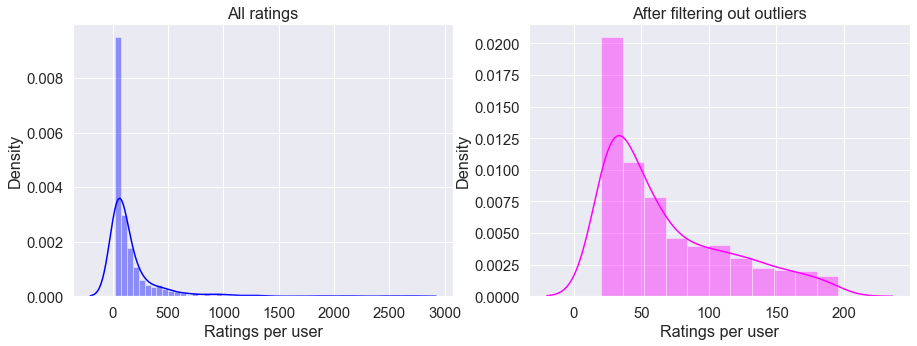

In [14]:
plot_two_hist(rating_counts,filtered_rating_counts,'Ratings per user','All ratings','After filtering out outliers')

In [15]:
rows_before = user_ratings.shape[0]
user_ratings = user_ratings.loc[(user_ratings.count(axis=1) <= UPPER_THRESH_USER)] #& (user_ratings.count(axis=1) > 2)
rows_after = user_ratings.shape[0]
print('Dropping {} users from user_ratings dataframe who ranked more than {} movies'.format((rows_before-rows_after),UPPER_THRESH_USER))

Dropping 133 users from user_ratings dataframe who ranked more than 200 movies


### b. Filtere out mainstream movies

In [16]:
UPPER_THRESH_MOVIE = 100 # max number of ratings per movie, beyond this, consider it as a mainstream!

In [17]:
movie_rates = user_ratings.count(axis=0) #Count non-NA cells for each column.
print('Some stats on number of ratings per movie...')
print('\tMin = %d'%min(movie_rates))
print('\tMax = %d'%max(movie_rates))
print('\tMean = %.2f'%np.mean(movie_rates))
print('\tStandard deviation = %.2f'%np.std(movie_rates))

Some stats on number of ratings per movie...
	Min = 0
	Max = 222
	Mean = 3.35
	Standard deviation = 11.14


In [18]:
filtered_movie_rates = reject_outliers(movie_rates,_max=UPPER_THRESH_MOVIE)
print('After filtering out outliers...')
print('\tMin = %d'%min(filtered_movie_rates))
print('\tMax = %d'%max(filtered_movie_rates))
print('\tMean = %.2f'%np.mean(filtered_movie_rates))
print('\tStandard deviation = %.2f'%np.std(filtered_movie_rates))

Filtering out 29 records with more than 100 counts...
After filtering out outliers...
	Min = 0
	Max = 99
	Mean = 2.97
	Standard deviation = 8.46


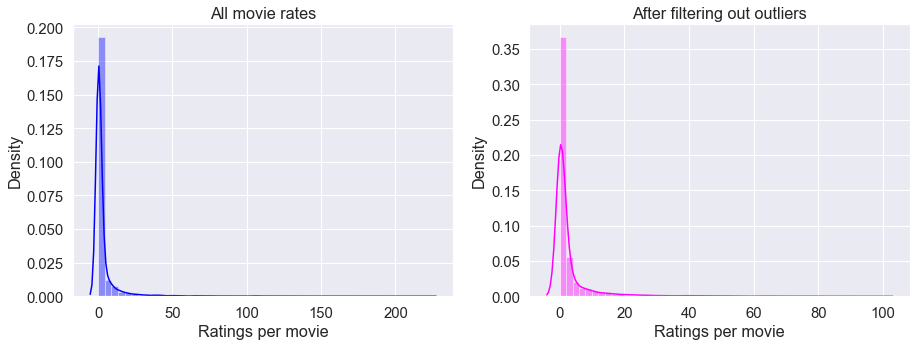

In [19]:
plot_two_hist(movie_rates,filtered_movie_rates,'Ratings per movie','All movie rates','After filtering out outliers')

In [20]:
cols_before = user_ratings.shape[1]
user_ratings = user_ratings.loc[:,(user_ratings.count(axis=0) <= UPPER_THRESH_MOVIE)]#& (user_ratings.count(axis=0) >= 2)
#df = df.loc[:, (df.isnull().sum(axis=0) <= max_number_of_nas)]
cols_after = user_ratings.shape[1]
print('Dropping {} movies from user_ratings dataframe who were ranked by more than {} users'.format((cols_before-cols_after),UPPER_THRESH_MOVIE))

Dropping 29 movies from user_ratings dataframe who were ranked by more than 100 users


In [21]:
print('users = %d, movies = %d'%(user_ratings.shape[0],user_ratings.shape[1]))

users = 477, movies = 9690


### Here, I manually add myself as a new user and I add my favourite movies to get recomenndations

In [30]:
#old_movies = ['shawshank redemption','forrest gump','groundhog day']
new_movies = ['days of summer','eat pray love','me before you','la la land','pursuit of happyness','interstellar']
# get movie ids which match the titles
my_movies = ['interstellar','inception','prestige']
simons_movies = ['grand budapest hotel', 'vicky cristina', 'casino royal']
for i in range(len(user_ratings.columns)):
    item = user_ratings.columns[i]
    for keyword in new_movies:
        if keyword in item.lower():
            print(i,user_ratings.columns[i])


8 (500) Days of Summer (2009)
2653 Eat Pray Love (2010)
4385 Interstellar (2014)
4852 La La Land (2016)
6875 Pursuit of Happyness, The (2006)


In [31]:
my_ratings = [np.nan]*len(user_ratings.columns)
my_ratings[8] = 5
my_ratings[2653] = 5
my_ratings[4852] = 3
my_ratings[6875] = 4

In [32]:
new_id = user_ratings.index.max()+1
print(new_id)

611


In [33]:
user_ratings.loc[new_id] = my_ratings

#### Just sanity check!!

In [34]:
my_ratings = user_ratings.loc[new_id].dropna()
my_ratings

title
(500) Days of Summer (2009)         5.0
Eat Pray Love (2010)                5.0
La La Land (2016)                   3.0
Pursuit of Happyness, The (2006)    4.0
Name: 611, dtype: float64

### Computing correlation score for every pair of columns, excluding NA/null values

#### I use min_period to consider a movie pair if and only if MIN_USERS users rated both movies, you can always change MIN_USERS, higher values make the prediction more conservative, lower values may make the predictions too general.. just play with it

In [35]:
MIN_USERS = 5 # for each pair of movies, the min number of users who ranked both of them
corr_matrix = user_ratings.corr(method='pearson', min_periods=MIN_USERS) #min_periods option currently only available for Pearson and Spearman correlation.
corr_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
recommend_list = pd.Series(dtype='float64')
for i in range(0, len(my_ratings.index)):
    
    sim_movies = corr_matrix[my_ratings.index[i]].dropna() #get similar movies whose correlation score is non NaN
    sim_movies = sim_movies.map(lambda x: x * my_ratings[i]) # scale the score by my rating
    recommend_list = recommend_list.append(sim_movies)
    print ("There are %d movies which has correlation with %s..." %(len(sim_movies),my_ratings.index[i]))

print("\nGrouping and sorting recommendation results:")
recommend_list = recommend_list.groupby(recommend_list.index).sum() # some of the recommended movies will be redundant since it'll be similar to more than one movie in my list so aggregate their scores
recommend_list = recommend_list.drop(my_ratings.index, errors='ignore') # remove the movies I already rated
recommend_list.sort_values(inplace = True, ascending = False)
recommend_list.head(15)

There are 75 movies which has correlation with (500) Days of Summer (2009)...
There are 0 movies which has correlation with Eat Pray Love (2010)...
There are 0 movies which has correlation with La La Land (2016)...
There are 66 movies which has correlation with Pursuit of Happyness, The (2006)...

Grouping and sorting recommendation results:


Bruce Almighty (2003)                                            6.027233
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    5.199459
Juno (2007)                                                      4.894366
Big Fish (2003)                                                  4.666128
Hangover, The (2009)                                             4.615853
Ratatouille (2007)                                               4.520893
Pretty Woman (1990)                                              4.429179
Harry Potter and the Chamber of Secrets (2002)                   4.230820
My Big Fat Greek Wedding (2002)                                  4.225771
Beautiful Mind, A (2001)                                         4.221766
V for Vendetta (2006)                                            4.187924
Good Will Hunting (1997)                                         4.180044
Titanic (1997)                                                   4.106899
Marley & Me (2008)                    

Wolf of Wall Street, The (2013)                     5.522101
Captain America: The Winter Soldier (2014)          4.867298
X-Men: First Class (2011)                           4.657758
Big Fish (2003)                                     4.414988
Kingsman: The Secret Service (2015)                 4.407070
Pan's Labyrinth (Laberinto del fauno, El) (2006)    4.139298
Rain Man (1988)                                     3.856056
Mad Max: Fury Road (2015)                           3.649939
Silver Linings Playbook (2012)                      3.616971
Deadpool (2016)                                     3.506967
Zootopia (2016)                                     3.432032
Girl with the Dragon Tattoo, The (2011)             3.361014
Shaun of the Dead (2004)                            3.322177
Prometheus (2012)                                   3.297784
Pursuit of Happyness, The (2006)                    3.277109
dtype: float64

### I enjoyed watching many of the movies on the recommendation list!


### <font color='blue'>To further improve the results:</font> 

* Scale user ratings, some users tend to be more genrous when rating a movie, others can be more conservative, one approach is to use MinMaxScaler from sklearn.preprocessing
* Split into train and test sets, construct correlation matrix from training data, hide sublest of movies in the test set and see if we can recommend the hidden movie list
* At the end, when enumerating the results, I scale the correlation score by movie rating (value between 1 and 5). An alternative approach is to map star rating to negative and positive scales {1_star: -2, 2_stars: -1, 3_stars: 0, 4_stars: 1, 5_stars: 2}.
* recommend hidden gems by filtering out main stream movies [added]